
Dataset Shape: (321584, 8)

First 5 rows of the dataset:
         time  latitude  longitude  clay_content  sand_content  silt_content  \
0  2013-01-03    54.875      9.125           5.0          86.0           9.0   
1  2013-01-05    54.875      9.125           5.0          86.0           9.0   
2  2013-01-07    54.875      9.125           5.0          86.0           9.0   
3  2013-01-08    54.875      9.125           5.0          86.0           9.0   
4  2013-01-09    54.875      9.125           5.0          86.0           9.0   

     sm_aux  sm_tgt  
0  0.454120    0.53  
1  0.437102    0.44  
2  0.412978    0.42  
3  0.378734    0.55  
4  0.350740    0.46  

Missing values in each column:
time            0
latitude        0
longitude       0
clay_content    0
sand_content    0
silt_content    0
sm_aux          0
sm_tgt          0
dtype: int64

Descriptive statistics of the dataset:
            latitude      longitude  clay_content   sand_content  \
count  321584.000000  321584.000

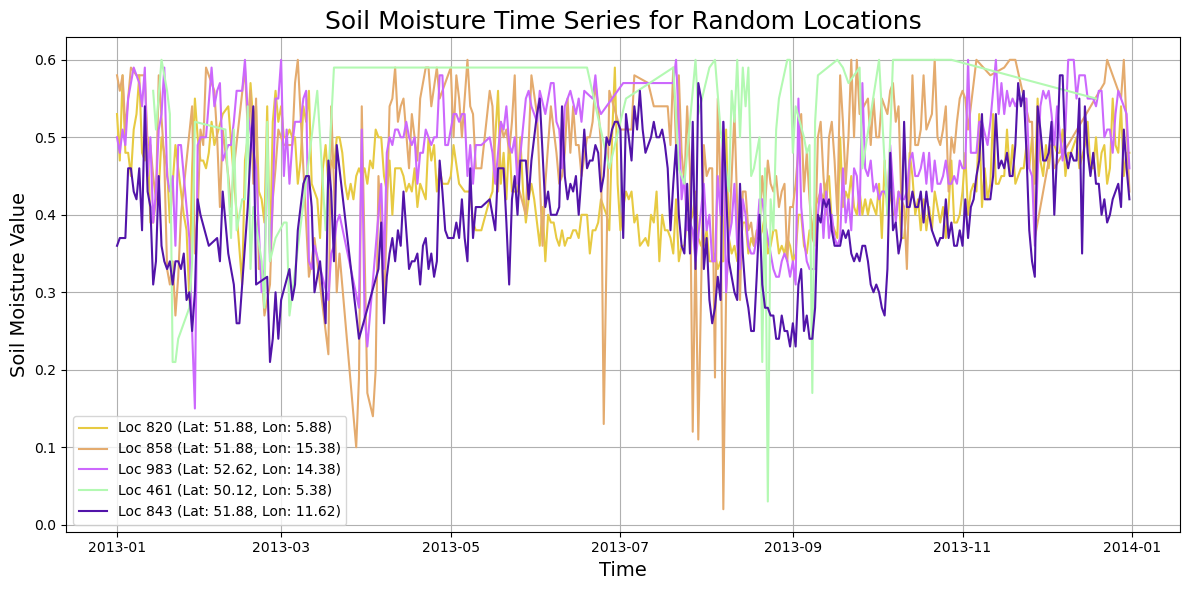

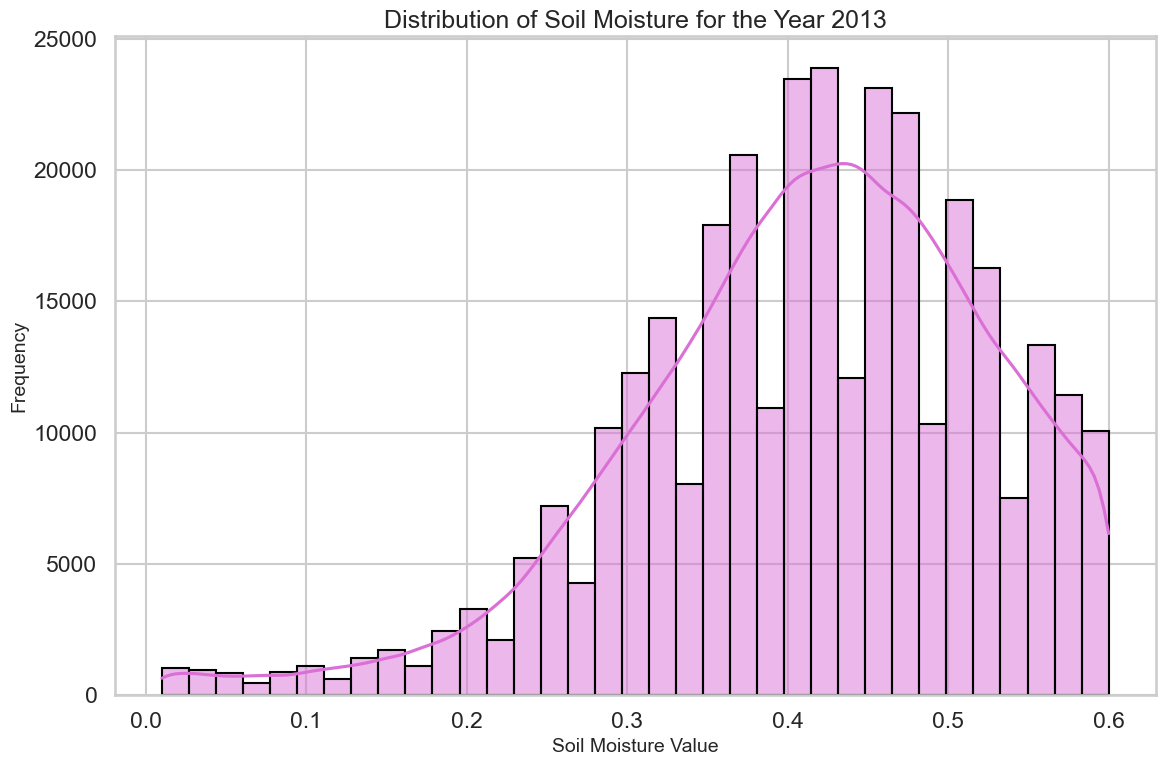

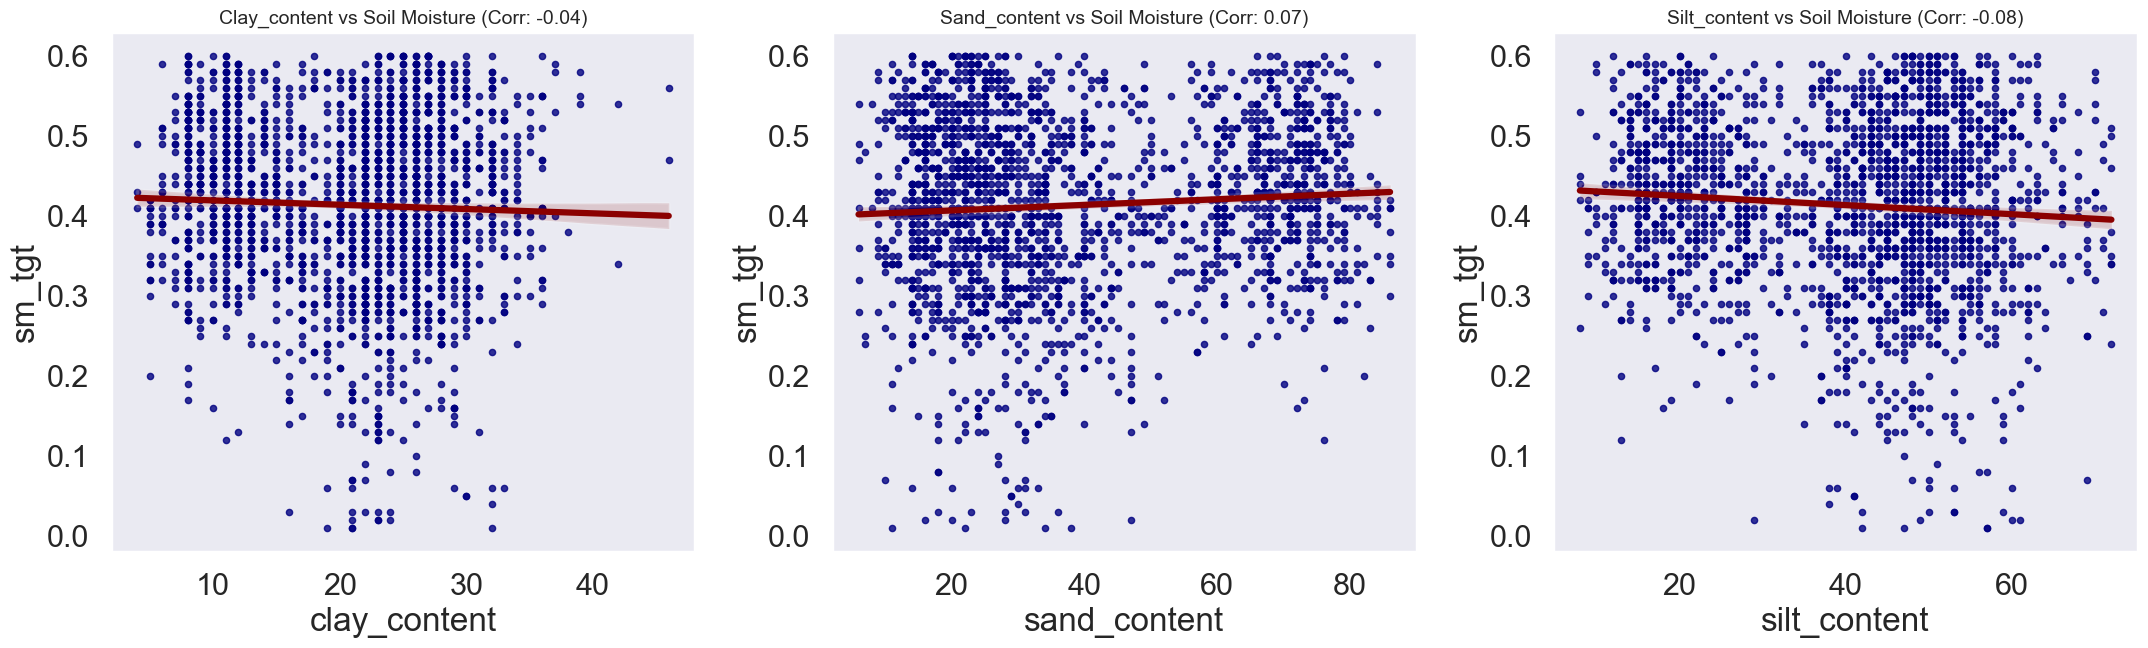



Epoch 1/10

1737/1737 [==============================] - 167s 92ms/step - loss: 0.0373 - val_loss: 0.0192
Epoch 2/10
1737/1737 [==============================] - 161s 93ms/step - loss: 0.0268 - val_loss: 0.0204
Epoch 3/10
1737/1737 [==============================] - 138s 79ms/step - loss: 0.0248 - val_loss: 0.0182
Epoch 4/10
1737/1737 [==============================] - 148s 85ms/step - loss: 0.0234 - val_loss: 0.0208
Epoch 5/10
1737/1737 [==============================] - 134s 77ms/step - loss: 0.0223 - val_loss: 0.0206
Epoch 6/10
1737/1737 [==============================] - 130s 75ms/step - loss: 0.0214 - val_loss: 0.0266
Epoch 7/10
1737/1737 [==============================] - 132s 76ms/step - loss: 0.0208 - val_loss: 0.0211
Epoch 8/10
1737/1737 [==============================] - 136s 78ms/step - loss: 0.0204 - val_loss: 0.0197
Epoch 9/10
1737/1737 [==============================] - 135s 77ms/step - loss: 0.0199 - val_loss: 0.0202
Epoch 10/10
1737/1737 [=============================

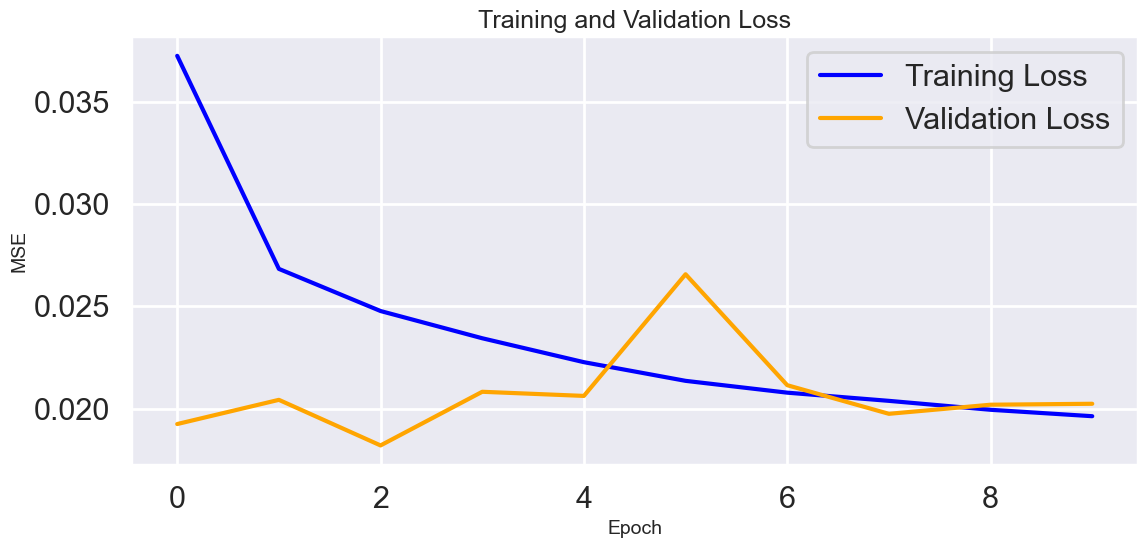

80/80 [==============================] - 5s 42ms/step


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, BatchNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, precision_score, recall_score, accuracy_score
from keras.callbacks import EarlyStopping

# Load the data
df = pd.read_csv('updated_data.csv')

# Data overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Descriptive statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())

# Determine unique latitude-longitude pairs
unique_locations = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(f"There are {unique_locations.shape[0]} unique locations in the dataset.")

# Create a unique identifier for each location
df['location_id'] = df.groupby(['latitude', 'longitude']).ngroup()

# Determine the start and end of the time series
start_date = df['time'].min()
end_date = df['time'].max()
print(f"The time series starts on {start_date} and ends on {end_date}.")

# Randomly select five unique location IDs
random_locations = np.random.choice(df['location_id'].unique(), 5, replace=False)

# Plot time series data for the selected locations
plt.figure(figsize=(12, 6))
for location in random_locations:
    subset = df[df['location_id'] == location]
    lat = subset['latitude'].iloc[0]
    lon = subset['longitude'].iloc[0]
    plt.plot(pd.to_datetime(subset['time']), subset['sm_tgt'], label=f"Loc {location} (Lat: {lat:.2f}, Lon: {lon:.2f})", color=np.random.rand(3,))
    
plt.title("Soil Moisture Time Series for Random Locations", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Soil Moisture Value", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Set style and context for distinct plot style
sns.set_style("whitegrid")
sns.set_context("talk")

# Create the distribution plot
plt.figure(figsize=(12, 8))
sns.histplot(df['sm_tgt'], kde=True, bins=35, color='orchid', edgecolor='black', linewidth=1.5)

# Set the title and labels
plt.title("Distribution of Soil Moisture for the Year 2013", fontsize=18)
plt.xlabel("Soil Moisture Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

# Randomly sample 2000 data points
sample_df = df.sample(n=2000, random_state=42)

# Set style for regression plots
sns.set_style("dark")
sns.set_context("poster")

# Initialize figure for subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 7))
components = ['clay_content', 'sand_content', 'silt_content']

for i, component in enumerate(components):
    sns.regplot(x=component, y='sm_tgt', data=sample_df, ax=axes[i], color='navy', scatter_kws={'s': 20}, line_kws={'color': 'darkred'})
    correlation = sample_df[component].corr(sample_df['sm_tgt'])
    axes[i].set_title(f"{component.capitalize()} vs Soil Moisture (Corr: {correlation:.2f})", fontsize=14)

plt.tight_layout()
plt.show()

# Normalize and split data
df['time'] = pd.to_datetime(df['time'])
june_data = df[df['time'].dt.month == 6]
df = df[df['time'].dt.month != 6]

features_to_normalize = ['latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
scaler = MinMaxScaler()

df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
june_data[features_to_normalize] = scaler.transform(june_data[features_to_normalize])

ordered_columns = ['time', 'latitude', 'longitude', 'clay_content', 'sand_content', 'silt_content', 'sm_aux', 'location_id', 'sm_tgt']
df = df[ordered_columns]
june_data = june_data[ordered_columns]

data_points_per_location = june_data.groupby('location_id').size()
locations_to_exclude = data_points_per_location[data_points_per_location < 15].index
june_data = june_data[~june_data['location_id'].isin(locations_to_exclude)]

def create_sequences(data, seq_length):
    X, Y = [], []
    for location, group in data.groupby('location_id'):
        features = group[features_to_normalize].drop(columns='sm_tgt').values
        targets = group['sm_tgt'].values
        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            Y.append(targets[i+seq_length])
    return X, Y

seq_length = 15
X, Y = create_sequences(df, seq_length)
X = np.array(X)
Y = np.array(Y)

# Build BiLSTM model
model = Sequential([
    Bidirectional(LSTM(75, activation='relu', return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(75, activation='relu')),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.2, verbose=1)

# Training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prepare June data
X_june, Y_june_true = create_sequences(june_data, seq_length)
X_june = np.array(X_june)
Y_june_true = np.array(Y_june_true)

predictions = model.predict(X_june, batch_size=128)

def reverse_scaling(data, scaler):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    dummy = np.zeros((len(data), len(features_to_normalize)))
    dummy[:, -1] = data.ravel()
    unscaled = scaler.inverse_transform(dummy)
    return unscaled[:, -1]

predictions_unscaled = reverse_scaling(predictions, scaler)
Y_june_true_unscaled = reverse_scaling(Y_june_true, scaler)


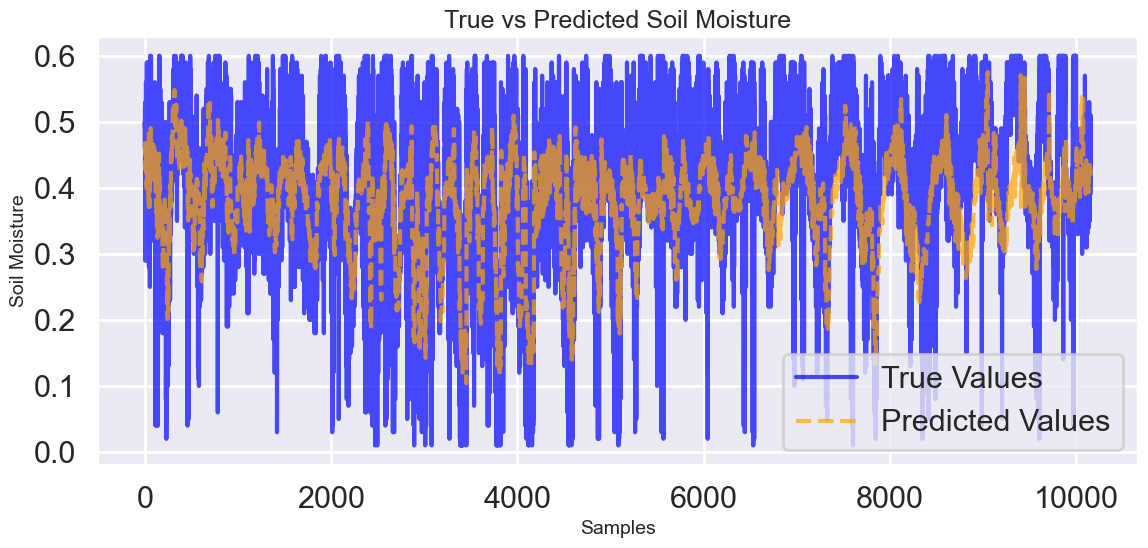

Mean Absolute Error (MAE): 0.0772
Root Mean Squared Error (RMSE): 0.0992
F1 Score: 0.0466
Precision: 0.4276
Recall: 0.0246
Accuracy: 0.7379


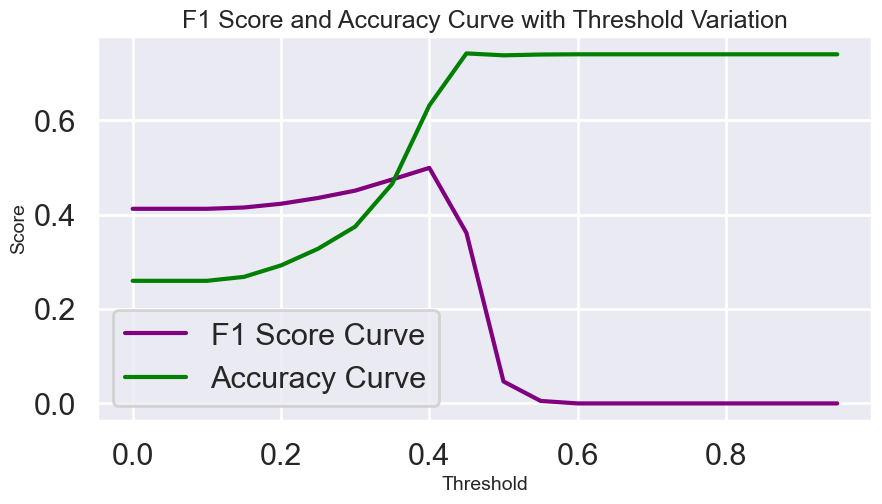

In [3]:
# Define plot_predictions function to visualize true vs predicted values
def plot_predictions(true_values, predicted_values):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label="True Values", color='blue', alpha=0.7)
    plt.plot(predicted_values, label="Predicted Values", color='orange', linestyle='dashed', alpha=0.7)
    plt.title("True vs Predicted Soil Moisture", fontsize=18)
    plt.xlabel("Samples", fontsize=14)
    plt.ylabel("Soil Moisture", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Now call the plot_predictions function after scaling reversal
plot_predictions(Y_june_true_unscaled, predictions_unscaled)

mae = mean_absolute_error(Y_june_true_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(Y_june_true_unscaled, predictions_unscaled))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Threshold to binarize predictions and true values (adjust the threshold as needed)
threshold = 0.5
Y_june_binary = (Y_june_true_unscaled >= threshold).astype(int)
predictions_binary = (predictions_unscaled >= threshold).astype(int)

# Calculate F1 score, Precision, Recall, and Accuracy
f1 = f1_score(Y_june_binary, predictions_binary)
precision = precision_score(Y_june_binary, predictions_binary)
recall = recall_score(Y_june_binary, predictions_binary)
accuracy = accuracy_score(Y_june_binary, predictions_binary)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plotting F1 Score and Accuracy Curve
plt.figure(figsize=(10, 5))
thresholds = np.arange(0, 1, 0.05)
f1_scores = [f1_score(Y_june_binary, (predictions_unscaled >= t).astype(int)) for t in thresholds]
accuracies = [accuracy_score(Y_june_binary, (predictions_unscaled >= t).astype(int)) for t in thresholds]

plt.plot(thresholds, f1_scores, label='F1 Score Curve', color='purple')
plt.plot(thresholds, accuracies, label='Accuracy Curve', color='green')
plt.title('F1 Score and Accuracy Curve with Threshold Variation', fontsize=18)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



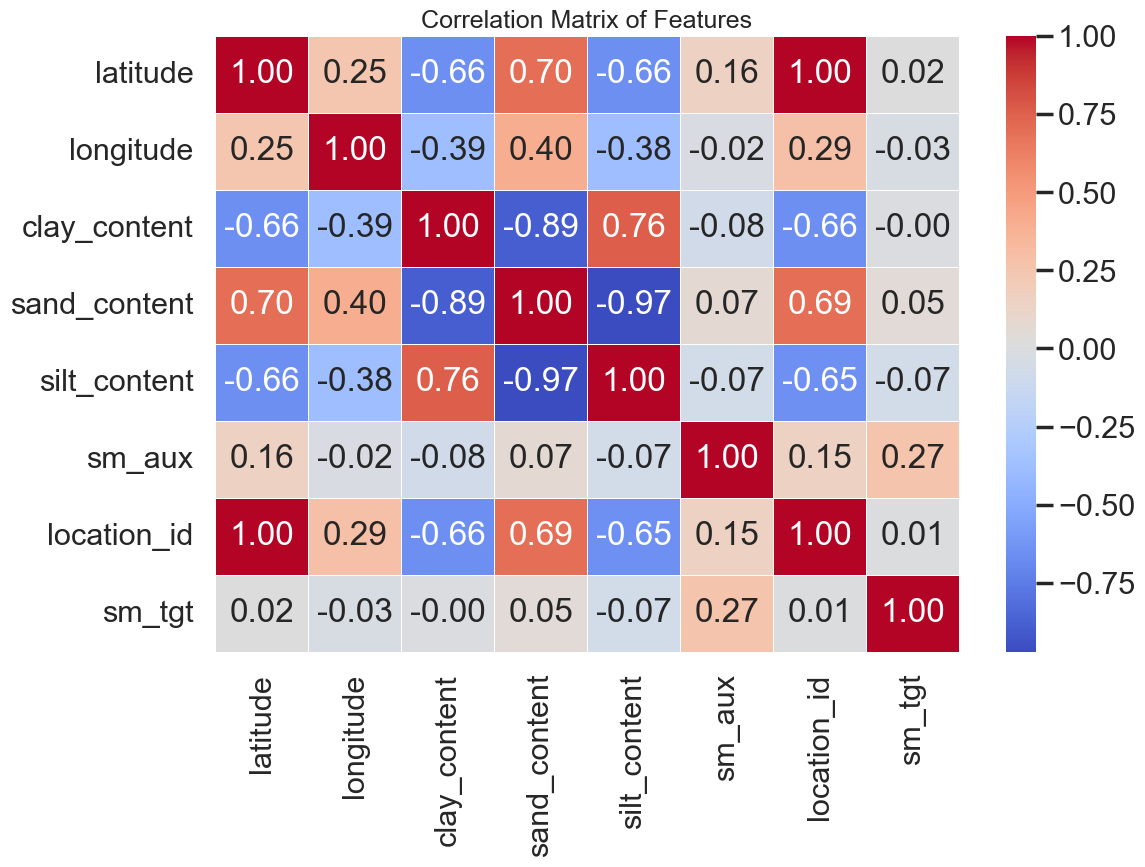

In [4]:
# Calculate the correlation matrix
correlation_matrix = df[features_to_normalize].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=18)
plt.show()
